<a href="https://colab.research.google.com/github/efandresena/large-scale-movie-recommendation/blob/main/mirindraf_mlas_practical_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Practical 3 : Model with embedding and enhanced data structue

## Data Structure Compressed Sparse Row with Numba

In [2]:
import numpy as np
from numba import njit, prange
import random


class CompactDatasetCSR:
    """
    CSR (Compressed Sparse Row) format optimized for Numba.
    Stores ratings as separate parallel arrays instead of structured arrays.
    """

    def __init__(self, shared_index=None):
        """
        Args:
            shared_index: Optional tuple of shared index mappings from another dataset
                         Format: (userId_to_idx, idx_to_userId, movieId_to_idx, idx_to_movieId)
        """
        if shared_index is not None:
            # Share index with another dataset (for train/test split)
            self.userId_to_idx, self.idx_to_userId, self.movieId_to_idx, self.idx_to_movieId = shared_index
            self._owns_index = False
        else:
            # Create new index
            self.userId_to_idx = {}
            self.idx_to_userId = []
            self.movieId_to_idx = {}
            self.idx_to_movieId = []
            self._owns_index = True



        # Temporary storage for ratings before finalization
        self._temp_ratings = []  # Store as list of (user_idx, movie_idx, rating)

        # CSR format for user ratings (row-based)
        self.user_indptr = None      # Pointer to start of each user's ratings
        self.user_movie_ids = None   # Flat array of movie indices
        self.user_ratings = None     # Flat array of ratings

        # CSR format for movie ratings (column-based)
        self.movie_indptr = None     # Pointer to start of each movie's ratings
        self.movie_user_ids = None   # Flat array of user indices
        self.movie_ratings = None    # Flat array of ratings

        self._finalized = False

    @property
    def usr_size(self):
        return len(self.idx_to_userId)

    @property
    def movie_size(self):
        return len(self.idx_to_movieId)

    def get_shared_index(self):
        """Return index mappings to share with another dataset."""
        return (self.userId_to_idx, self.idx_to_userId,
                self.movieId_to_idx, self.idx_to_movieId)

    def add_rating(self, userId, movieId, rating_value):
        """Add a rating entry to the dataset."""
        if self._finalized:
            raise RuntimeError("Cannot add ratings after finalization")

        # Index user (only if we own the index)
        if self._owns_index:
            if userId not in self.userId_to_idx:
                user_pos = len(self.idx_to_userId)
                self.userId_to_idx[userId] = user_pos
                self.idx_to_userId.append(userId)

        # Index movie (only if we own the index)
        if self._owns_index:
            if movieId not in self.movieId_to_idx:
                movie_pos = len(self.idx_to_movieId)
                self.movieId_to_idx[movieId] = movie_pos
                self.idx_to_movieId.append(movieId)

        # Get indices
        user_pos = self.userId_to_idx.get(userId)
        movie_pos = self.movieId_to_idx.get(movieId)

        # Only add if both user and movie exist in index here pos mean the list index row and colum
        if user_pos is not None and movie_pos is not None:
            self._temp_ratings.append((user_pos, movie_pos, rating_value))


    def finalize(self):
        """Convert to CSR format for Numba optimization."""
        if self._finalized:
            return

        print(f"Finalizing dataset to CSR format... ({len(self._temp_ratings)} ratings)")

        M = self.usr_size
        N = self.movie_size


        # Sort ratings by user, then by movie (for CSR user format)
        print("  Sorting by user...")
        self._temp_ratings.sort(key=lambda x: (x[0], x[1]))


        # Build user CSR arrays
        print("  Building user CSR arrays...")
        self.user_indptr = np.zeros(M + 1, dtype=np.int64)
        self.user_movie_ids = np.zeros(len(self._temp_ratings), dtype=np.int32)
        self.user_ratings = np.zeros(len(self._temp_ratings), dtype=np.float32)

        current_user = -1
        for idx, (user_idx, movie_idx, rating) in enumerate(self._temp_ratings):
            # Update indptr for new users
            while current_user < user_idx:
                current_user += 1
                self.user_indptr[current_user] = idx

            self.user_movie_ids[idx] = movie_idx
            self.user_ratings[idx] = rating

        # Fill remaining indptr
        while current_user < M:
            current_user += 1
            self.user_indptr[current_user] = len(self._temp_ratings)


        # Sort ratings by movie, then by user (for CSR movie format)
        print("  Sorting by movie...")
        self._temp_ratings.sort(key=lambda x: (x[1], x[0]))

        # Build movie CSR arrays
        print("  Building movie CSR arrays...")
        self.movie_indptr = np.zeros(N + 1, dtype=np.int64)
        self.movie_user_ids = np.zeros(len(self._temp_ratings), dtype=np.int32)
        self.movie_ratings = np.zeros(len(self._temp_ratings), dtype=np.float32)

        current_movie = -1
        for idx, (user_idx, movie_idx, rating) in enumerate(self._temp_ratings):
            # Update indptr for new movies
            while current_movie < movie_idx:
                current_movie += 1
                self.movie_indptr[current_movie] = idx

            self.movie_user_ids[idx] = user_idx
            self.movie_ratings[idx] = rating

        # Fill remaining indptr
        while current_movie < N:
            current_movie += 1
            self.movie_indptr[current_movie] = len(self._temp_ratings)

        # Free temporary memory
        self._temp_ratings = None

        self._finalized = True
        print(f"✓ Finalized: {self}")

    def __repr__(self):
        if self._finalized:
            total = len(self.user_ratings) if self.user_ratings is not None else 0
        else:
            total = len(self._temp_ratings)
        return f"CompactDatasetCSR(users={self.usr_size}, movies={self.movie_size}, ratings={total})"




## Function update user biases and factors

In [3]:
@njit(parallel=True, fastmath=True)
def update_user_biases_and_factors(user_biases, u, item_biases, v,
                                   user_indptr, user_movie_ids, user_ratings,
                                   lamda, gamma, k):
    """Update all user biases and latent factors in parallel."""
    M = len(user_biases)

    for m in prange(M):
        start = user_indptr[m]
        end = user_indptr[m + 1]
        omega = end - start # number of the movie user rated

        if omega == 0:
            continue

        # Update user bias
        numerator = 0.0
        for idx in range(start, end): # for every movie n a given user m rated it with rating n
            n = user_movie_ids[idx]
            r = user_ratings[idx]
            pred_no_bias = 0.0
            for d in range(k): # numpy dot product is not efficient with numba so this could be just donewith np.dot(U[m], V[n])
                pred_no_bias += u[m, d] * v[n, d] # same as  uₙvₙᵀ
            numerator += r - item_biases[n] - pred_no_bias

        user_biases[m] = lamda * numerator / (lamda * omega + gamma) # update

        # Update user latent factors Um = A^-1 * b # dim => inv(k,k)* (k,) => (k,)
        # Build A = λ∑vₙvₙᵀ + γI  and b = λ∑vₙ(rₘₙ - bᵤₘ - bᵢₙ)

        A = np.zeros((k, k), dtype=np.float32)
        b = np.zeros(k, dtype=np.float32)

        for idx in range(start, end):
            n = user_movie_ids[idx]
            r = user_ratings[idx]

            # A += vₙvₙᵀ
            for i in range(k):
                for j in range(k):
                    A[i, j] += v[n, i] * v[n, j]

            # b += vₙ * residual
            residual = r - user_biases[m] - item_biases[n]
            for i in range(k):
                b[i] += v[n, i] * residual

        # A = λA + γI
        for i in range(k):
            for j in range(k):
                A[i, j] *= lamda
            A[i, i] += gamma

        # b = λb
        for i in range(k):
            b[i] *= lamda

        # Solve A^-1b = u ==> Au = b using Cholesky decomposition
        u[m, :] = np.linalg.solve(A, b)




## Function update movie biases and factors

In [4]:
@njit(parallel=True, fastmath=True)
def update_item_biases_and_factors(item_biases, v, user_biases, u,
                                   movie_indptr, movie_user_ids, movie_ratings,
                                   lamda, gamma, k):
    """Update all item biases and latent factors in parallel."""
    N = len(item_biases)

    for n in prange(N):
        start = movie_indptr[n]
        end = movie_indptr[n + 1]
        omega = end - start

        if omega == 0:
            continue

        # Update item bias
        numerator = 0.0
        for idx in range(start, end):
            m = movie_user_ids[idx]
            r = movie_ratings[idx]
            pred_no_bias = 0.0
            for d in range(k):
                pred_no_bias += v[n, d] * u[m, d]
            numerator += r - user_biases[m] - pred_no_bias

        item_biases[n] = lamda * numerator / (lamda * omega + gamma)

        # Update item latent factors
        A = np.zeros((k, k), dtype=np.float32)
        b = np.zeros(k, dtype=np.float32)

        for idx in range(start, end):
            m = movie_user_ids[idx]
            r = movie_ratings[idx]

            # A += uₘuₘᵀ
            for i in range(k):
                for j in range(k):
                    A[i, j] += u[m, i] * u[m, j]

            # b += uₘ * residual
            residual = r - user_biases[m] - item_biases[n]
            for i in range(k):
                b[i] += u[m, i] * residual

        # A = λA + γI
        for i in range(k):
            for j in range(k):
                A[i, j] *= lamda
            A[i, i] += gamma

        # b = λb
        for i in range(k):
            b[i] *= lamda

        v[n, :] = np.linalg.solve(A, b)




## Computing metrics during training : Loss and RMSE

In [5]:
@njit(parallel=True, fastmath=True)
def compute_metrics_numba(user_indptr, user_movie_ids, user_ratings,
                         user_biases, item_biases, u, v, gamma):
    """Compute loss and RMSE in parallel."""
    M = len(user_biases)
    k = u.shape[1]

    # Parallel reduction for squared error
    sq_errors = np.zeros(M, dtype=np.float64)
    counts = np.zeros(M, dtype=np.int64)

    for m in prange(M):
        start = user_indptr[m]
        end = user_indptr[m + 1]

        local_sq_err = 0.0
        for idx in range(start, end):
            n = user_movie_ids[idx]
            r = user_ratings[idx]

            pred = user_biases[m] + item_biases[n]
            for d in range(k):
                pred += u[m, d] * v[n, d]

            diff = r - pred
            local_sq_err += diff * diff

        sq_errors[m] = local_sq_err
        counts[m] = end - start

    sq_err = np.sum(sq_errors)
    count = np.sum(counts)

    # Regularization term
    reg_term = gamma * (
        np.sum(user_biases ** 2) +
        np.sum(item_biases ** 2) +
        np.sum(u ** 2) +
        np.sum(v ** 2)
    )

    loss = 0.5 * (sq_err + reg_term)
    rmse = np.sqrt(sq_err / count) if count > 0 else 0.0

    return loss, rmse



## Training loop function

In [6]:
def train_als(train, test, k=2, lamda=0.1, gamma=0.1, epochs=5):
    """
    Optimized ALS training with Numba..
    """
    M, N = train.usr_size, train.movie_size

    loss_trains = []
    loss_test = []
    rmse_trains = []
    rmse_tests = []
    # Initialize parameters
    user_biases = np.zeros(M, dtype=np.float32)
    item_biases = np.zeros(N, dtype=np.float32)

    norm_f = 1.0 / np.sqrt(k)
    u = norm_f * np.random.normal(0, 1, (M, k)).astype(np.float32) # row vectors
    v = norm_f * np.random.normal(0, 1, (N, k)).astype(np.float32) # row vectors

    print(f"\nTraining ALS with Numba: {M} users, {N} movies, {epochs} epochs, k={k}")
    print(f"Total ratings: {len(train.user_ratings)}")

    # JIT compile functions on first call
    print("Compiling Numba functions. Wait...")

    for epoch in range(epochs):
        # Update users (parallel) # with numba t=we modify variables in place so no needfor function to return :
        update_user_biases_and_factors(
            user_biases, u, item_biases, v,
            train.user_indptr, train.user_movie_ids, train.user_ratings,
            lamda, gamma, k
        )

        # Update items (parallel)
        update_item_biases_and_factors(
            item_biases, v, user_biases, u,
            train.movie_indptr, train.movie_user_ids, train.movie_ratings,
            lamda, gamma, k
        )

        # Compute metrics
        loss_tr, rmse_tr = compute_metrics_numba(
            train.user_indptr, train.user_movie_ids, train.user_ratings,
            user_biases, item_biases, u, v, gamma
        )
        loss_te, rmse_te = compute_metrics_numba(
            test.user_indptr, test.user_movie_ids, test.user_ratings,
            user_biases, item_biases, u, v, gamma
        )

        loss_trains.append(loss_tr)
        loss_test.append(loss_te)

        rmse_trains.append(rmse_tr)
        rmse_tests.append(rmse_te)

        print(f"Epoch {epoch+1:3d}  "
              f"Loss(tr)={loss_tr:.4f} Loss(te)={loss_te:.4f}  "
              f"RMSE(tr)={rmse_tr:.4f} RMSE(te)={rmse_te:.4f}")



    return user_biases, item_biases, u, v, (loss_trains,loss_test, rmse_trains, rmse_tests)



## Function to load the data

In [7]:
def load_data(filepath, test_ratio=0.2, seed=42):
    """
    Load dataset  train/test split that maintains shared indices.
    If only want to load the dataset set test_ratio = 0
    CRITICAL: Train and test must share the same user/movie index mappings!
    """
    random.seed(seed)

    # Step 1: Create TRAIN dataset first
    print("=" * 60)
    print("STEP 1: Loading TRAIN dataset (building index)...")
    print("=" * 60)
    train = CompactDatasetCSR()  # Owns the index

    # Step 2: Create TEST dataset sharing train's index
    print("\nSTEP 2: Creating TEST dataset (sharing train's index)...")
    test = CompactDatasetCSR(shared_index=train.get_shared_index())

    # Step 3: Load data and split
    print("\nSTEP 3: Loading data from CSV...")
    train_count = 0
    test_count = 0

    with open(filepath, 'r') as file:
        next(file)  # Skip header

        for i, line in enumerate(file):
            if i % 1_000_000 == 0 and i > 0:
                print(f"  Processed {i//1_000_000}M lines... "
                      f"(train: {train_count:,}, test: {test_count:,})")

            userId, movieId, rating, _ = line.strip().split(',')
            rating = float(rating)

            # Random split with consistent ratio
            if random.random() < test_ratio:
                test.add_rating(userId, movieId, rating)
                test_count += 1
            else:
                train.add_rating(userId, movieId, rating)
                train_count += 1

    print(f"\n✓ Loaded {train_count:,} train ratings, {test_count:,} test ratings")
    print(f"  Users: {train.usr_size:,}, Movies: {train.movie_size:,}")

    # Step 4: Finalize both datasets
    print("\nSTEP 4: Finalizing datasets...")
    train.finalize()
    test.finalize()

    print("\n" + "=" * 60)
    print("DATASET READY!")
    print("=" * 60)
    print(f"Train: {train}")
    print(f"Test:  {test}")
    print("=" * 60 + "\n")

    return train, test

## Load the 25M dataset and train the model

In [16]:
# Save the artifact code to a file called 'optimized_als.py'
# Then run:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip
link = "/content/ml-25m/ratings.csv"

# # 1. Load data
print("Loading MovieLens-25M dataset...")
train, test = load_data(link, test_ratio=0.2, seed=42)


--2025-11-22 12:25:00--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  21.1MB/s    in 13s     

2025-11-22 12:25:14 (19.0 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       
Loading MovieLens-25M dataset...
STEP 1: Loading TRAIN dataset (building index)...

STEP 2: Creating TEST dataset (sharing train's index)...

STEP 3: Loading data from CSV...


In [22]:
# 3. Train the model
print("\nStarting training...")
user_biases, item_biases, u, v, (loss_trains,loss_test, rmse_trains, rmse_tests) = train_als(
    train, test,
    k=15,           # Latent factors
    lamda=0.1,      # Learning rate
    gamma=0.5,      # Regularization
    epochs=20    # Number of iterations
)

embeddings2 = [user_biases, item_biases, u, v, (loss_trains,loss_test, rmse_trains, rmse_tests) ]

print("\n✓ Training complete!")


Starting training...

Training ALS with Numba: 162541 users, 56713 movies, 20 epochs, k=15
Total ratings: 19999499
Compiling Numba functions. Wait...
Epoch   1  Loss(tr)=7206322.1040 Loss(te)=2515110.2163  RMSE(tr)=0.8197 RMSE(te)=0.9054
Epoch   2  Loss(tr)=6143107.1766 Loss(te)=2249653.5703  RMSE(tr)=0.7554 RMSE(te)=0.8561
Epoch   3  Loss(tr)=5649104.1448 Loss(te)=2086328.6519  RMSE(tr)=0.7253 RMSE(te)=0.8285
Epoch   4  Loss(tr)=5393902.6131 Loss(te)=1986947.0127  RMSE(tr)=0.7102 RMSE(te)=0.8137
Epoch   5  Loss(tr)=5251436.8821 Loss(te)=1924072.5726  RMSE(tr)=0.7025 RMSE(te)=0.8062
Epoch   6  Loss(tr)=5165071.0797 Loss(te)=1881158.4451  RMSE(tr)=0.6982 RMSE(te)=0.8021
Epoch   7  Loss(tr)=5107285.3498 Loss(te)=1849373.4968  RMSE(tr)=0.6957 RMSE(te)=0.7997
Epoch   8  Loss(tr)=5065391.8272 Loss(te)=1824371.2893  RMSE(tr)=0.6940 RMSE(te)=0.7982
Epoch   9  Loss(tr)=5033203.9191 Loss(te)=1803857.1013  RMSE(tr)=0.6928 RMSE(te)=0.7970
Epoch  10  Loss(tr)=5007406.7690 Loss(te)=1786515.3242  R

In [23]:
import pickle
import os

# Define the target directory and filename
target_directory = '/content/drive/MyDrive/BLOC#3/ML_at_Large_Scale/2dembeddings'
filename = 'embeddings2.pkl'
file_path = os.path.join(target_directory, filename)

# Create the directory if it doesn't exist
os.makedirs(target_directory, exist_ok=True)

# Save embeddings2 to a pickle file
with open(file_path, 'wb') as f:
    pickle.dump(embeddings2, f)

print(f"embeddings2 successfully saved to '{file_path}'")

embeddings2 successfully saved to '/content/drive/MyDrive/BLOC#3/ML_at_Large_Scale/2dembeddings/embeddings15k.pkl'


In [24]:

filename = 'model_run_params.pkl'
file_path = os.path.join(target_directory, filename)

k_val = 2
lamda_val = 0.01
gamma_val = 0.01

# Combine the parameters into a dictionary
model_run_params = {
    'train': train,
    'test': test,
    'k': k_val,
    'lamda': lamda_val,
    'gamma': gamma_val
}

# Save model_run_params to a pickle file
with open(file_path, 'wb') as f:
    pickle.dump(model_run_params, f)

print(f"Model run parameters successfully saved to '{file_path}'")

Model run parameters successfully saved to '/content/drive/MyDrive/BLOC#3/ML_at_Large_Scale/2dembeddings/model_run_params15k.pkl'


## Plot evolution loss and rmse

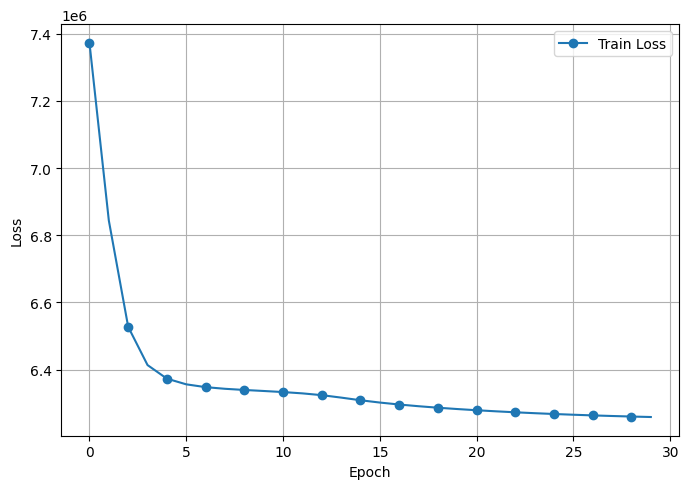

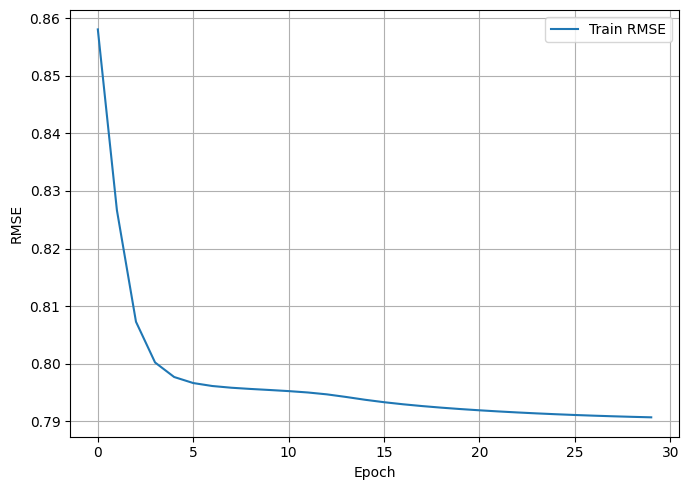

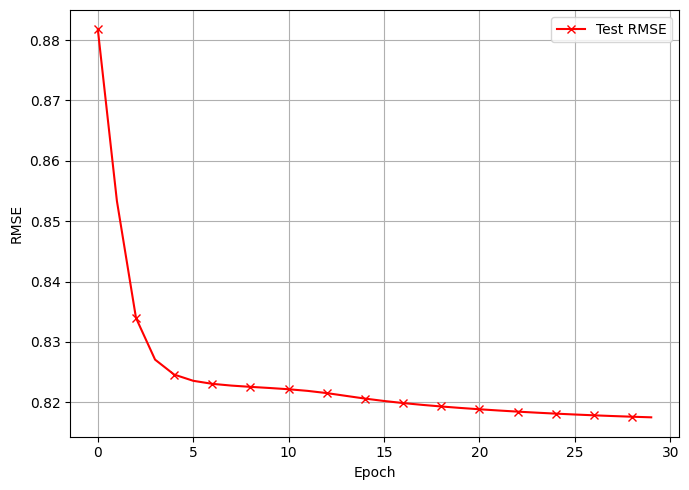

In [20]:
import matplotlib.pyplot as plt

# ================================
# 1. TRAIN LOSS → 25M_train_loss.pdf
# ================================
plt.figure(figsize=(7,5))
plt.plot(
    loss_trains,
    label="Train Loss",
    marker='o',
    markevery=2,
    linestyle='-'
)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("25M_uv_train_loss.pdf")
plt.show()


# ================================
# 3. TRAIN RMSE → 25M_train_rmse.pdf
# ================================
plt.figure(figsize=(7,5))
plt.plot(
    rmse_trains,
    label="Train RMSE",
)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("25M_uv_train_rmse.pdf")
plt.show()

# ================================
# 4. TEST RMSE → 25M_test_rmse.pdf
# ================================
plt.figure(figsize=(7,5))
plt.plot(
    rmse_tests,
    label="Test RMSE",
    marker='x',
    markevery=2,
    linestyle='-',
    color='red'
)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("25M_uv_test_rmse.pdf")
plt.show()
